In [1]:
# Converts a dataBatch (iterable of [image_batch, label_batch]) 
# into a tuple of two lists: one list of image batches, another of corresponding label batches.
def from_DataBatch_to_list(dataBatch):
  val_dataset2 = []  # list to collect image batches
  val_dataset2_gt = []  # list to collect ground truth batches
  i = 0  # index counter for elements within batch (0: images, 1: labels)

  # Iterate over each batch in the provided dataBatch
  for batch in dataBatch:
    # Each batch is expected to be a sequence where index 0 is images and index 1 is labels
    for i in range(len(batch)):
      if i == 0:
        val_dataset2.append(batch[i])  # append image batch
      if i == 1:
        val_dataset2_gt.append(batch[i])  # append label batch
    
  # Return a tuple (images_list, labels_list)
  return (val_dataset2, val_dataset2_gt)


In [2]:
import torch

def topk_accuracy(model, k, validation_tuple, device=None):
    """
    Compute Top-K accuracy for a PyTorch model over a validation dataset.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        k (int): Number of top predictions to consider for accuracy.
        validation_tuple (tuple): A tuple (val_data, val_labels), where
            - val_data is a list of input batches (torch.Tensor) of shape [B, C, H, W]
            - val_labels is a list of corresponding label batches, either as class indices [B]
        device (torch.device, optional): Device to run inference on. If None, uses CUDA if available.

    return:
        float: Top-K accuracy over the entire validation set.
    """
    # Unpack validation data and labels
    val_data, val_labels = validation_tuple

    # Select device: use GPU if available and not specified
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()

    correct = 0  # Counter for correctly predicted samples
    total = 0    # Counter for total samples

    # Disable gradient computation for inference
    with torch.no_grad():
        # Iterate over batches of inputs and labels
        for x_batch, y_batch in zip(val_data, val_labels):
            # Move batch to the selected device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass: obtain raw logits of shape [B, num_classes]
            outputs = model(x_batch)

            # Get the indices of the top-k predictions for each sample [B, k]
            topk_inds = outputs.topk(k, dim=1).indices

            # If labels are one-hot encoded, convert to class indices
            if y_batch.dim() > 1:
                y_true = y_batch.argmax(dim=1)
            else:
                y_true = y_batch  # Already class indices

            # Compare true labels against top-k predictions: [B, k] boolean tensor
            matches = topk_inds.eq(y_true.unsqueeze(1))

            # Count samples where the true label is among the top-k predictions
            correct += matches.any(dim=1).sum().item()
            total += x_batch.size(0)

    # Return the ratio of correct predictions
    return correct / total


In [3]:
import torch

def confusion_matrix(model, failure_types, validation_tuple, thresholds, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()
    
    val_batches, label_batches = validation_tuple
    C = len(failure_types)
    defect_classes = C - 1  # 'none' 인덱스
    
    all_true = []
    all_pred = []
    all_prob = []
    
    with torch.no_grad():
        for x_batch, y_batch in zip(val_batches, label_batches):
            x = x_batch
            # --- 입력 차원 보정 ---
            # 3D: (H, W, C) → (1, C, H, W)
            if isinstance(x, torch.Tensor) and x.dim() == 3:
                if x.shape[-1] == 3:
                    x = x.permute(2, 0, 1).contiguous()
                x = x.unsqueeze(0)
            # 4D NHWC: (B, H, W, C) → (B, C, H, W)
            elif isinstance(x, torch.Tensor) and x.dim() == 4 and x.shape[-1] == 3:
                x = x.permute(0, 3, 1, 2).contiguous()
            
            x = x.to(device).float()
            logits = model(x)                      
            probs  = torch.softmax(logits, dim=1)  
            
            # --- 레이블 정리 ---
            if isinstance(y_batch, torch.Tensor):
                y = y_batch.to(device)
                if y.dim() > 1:
                    y_list = y.argmax(dim=1).cpu().tolist()
                else:
                    y_list = y.cpu().tolist()
            elif isinstance(y_batch, (list, tuple)):
                y_list = list(y_batch)
            else:
                y_list = [int(y_batch)]
            
            all_true.extend(y_list)
            
            # defect 클래스 중 top-k=1 예측
            top_probs, top_idx = probs[:, :defect_classes].max(dim=1)
            all_pred.extend(top_idx.cpu().tolist())
            all_prob.extend(top_probs.cpu().tolist())
    
    # --- 혼동행렬 만들기 ---
    if thresholds:
        cms = []
        for thr in thresholds:
            cm = [[0]*C for _ in range(C)]
            for t, p, prob in zip(all_true, all_pred, all_prob):
                pred_idx = p if prob > thr else (C-1)
                cm[t][pred_idx] += 1
            cms.append(cm)
        return cms
    else:
        cm = [[0]*C for _ in range(C)]
        for t, p in zip(all_true, all_pred):
            cm[t][p] += 1
        return cm


In [4]:
def classes_proportion_correctly_classified(c_matrix, failure_types):
  dict_ = {}
  for i in range(len(failure_types)):
    dict_[failure_types[i]] = c_matrix[i][i]/np.sum(c_matrix[i])
  
  return dict_

In [5]:
def metrics_report(c_matrix):
  precision = 0
  recall = 0

  num = 0
  precision_den = 0
  recall_den = 0

  for i in range(len(c_matrix)):
  # Index 8 is assumed to represent the negative class
    if (i != 8):
      num += c_matrix[i][i]
      precision_den += c_matrix[i][i] + c_matrix[8][i]
      recall_den += c_matrix[i][i] + c_matrix[i][8]
    

  precision = num/precision_den
  recall = num/recall_den
  return (
      {'precision': precision, 
       'recall': recall,
       'f1-measure': 2*(precision*recall)/(precision+recall)})

In [6]:
def roc_auc_report(confusion_matrixes):
  tp_rates = []
  fp_rates = []

  for l in range(len(confusion_matrixes)):
    tp = 0; fn = 0
    fp = 0; tn = 0

    cm = confusion_matrixes[l]

    for i in range(len(cm)):
      if (i != 8):
        tp += cm[i][i] 
        fn += cm[i][8]
        fp += cm[8][i]
      
      if (i == 8):
        tn = cm[i][i]
  
    tp_rates.append(tp/(tp+fn))
    fp_rates.append(fp/(fp+tn))

  return (tp_rates, fp_rates)

In [7]:
import copy
import matplotlib.pyplot as plt

def roc_curve(tp_rates, fp_rates):
  tp = copy.deepcopy(tp_rates)
  #tp.extend([0])
  tp.reverse()

  fp = copy.deepcopy(fp_rates)
  #fp.extend([0])
  fp.reverse()

  plt.plot(fp, tp)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.xlabel("false positive rate") 
  plt.ylabel("true positive rate")
  plt.title("ROC curve")

In [8]:
import numpy as np

threshold1 = np.arange(0, 1, 0.01).tolist()
threshold2 = []

## Model 0: base

In [11]:
import json
import pandas as pd

with open('C://Users/isang/OneDrive/Desktop/WM/data/WM811K_train_padded_resized_not_augmented.json', 'r') as f:
  data = json.load(f)

cols = data['columns']

dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 0:
      dict_[cols[i]].append(data['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data['data'][j][i])
      
data = pd.DataFrame(dict_)


classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training = [0] * 9

for i in range(len(training)):
  training[i] = data[data['failureType'] == classes[i]]
  training[i] = training[i].reset_index(drop = True)

In [12]:
validation = []

for i in range(len(training)):
  validation.append(training[i].sample(frac = 0.2))
  training[i].drop(validation[i].index, inplace=True)

In [25]:
training[0].head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center


In [ ]:
import os
import shutil
import matplotlib

base_dir   = r"C://Users/isang/OneDrive/Desktop/WM/data/"
train_dir  = os.path.join(base_dir, "WM811K_train")
val_dir    = os.path.join(base_dir, "WM811K_val")

for d in (train_dir, val_dir):
    if os.path.exists(d):
        shutil.rmtree(d)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir,   exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir,   cls), exist_ok=True)

for i in range(len(classes)):
  for j in range(len(training[i])):
    if(j%1000 == 0):
      print('/WM811K_train/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('C://Users/isang/OneDrive/Desktop/WM/data/WM811K_train/'+classes[i]+'/'+str(j)+'.png', training[i]['waferMap'].iloc[j])


for i in range(len(classes)):
  for j in range(len(validation[i])):
    if(j%1000 == 0):
      print('/WM811K_val/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('C://Users/isang/OneDrive/Desktop/WM/data/WM811K_val/'+classes[i]+'/'+str(j)+'.png', validation[i]['waferMap'].iloc[j])
     

/WM811K_train/Center/0.png
/WM811K_train/Center/1000.png
/WM811K_train/Center/2000.png
/WM811K_train/Donut/0.png
/WM811K_train/Edge-Loc/0.png
/WM811K_train/Edge-Loc/1000.png
/WM811K_train/Edge-Loc/2000.png
/WM811K_train/Edge-Loc/3000.png
/WM811K_train/Edge-Ring/0.png
/WM811K_train/Edge-Ring/1000.png
/WM811K_train/Edge-Ring/2000.png
/WM811K_train/Edge-Ring/3000.png
/WM811K_train/Edge-Ring/4000.png
/WM811K_train/Edge-Ring/5000.png
/WM811K_train/Edge-Ring/6000.png
/WM811K_train/Loc/0.png
/WM811K_train/Loc/1000.png
/WM811K_train/Loc/2000.png
/WM811K_train/Near-full/0.png
/WM811K_train/Random/0.png
/WM811K_train/Scratch/0.png
/WM811K_train/none/0.png
/WM811K_train/none/1000.png
/WM811K_train/none/2000.png
/WM811K_train/none/3000.png
/WM811K_train/none/4000.png
/WM811K_train/none/5000.png
/WM811K_train/none/6000.png
/WM811K_train/none/7000.png
/WM811K_train/none/8000.png
/WM811K_train/none/9000.png
/WM811K_train/none/10000.png
/WM811K_train/none/11000.png
/WM811K_train/none/12000.png
/WM811K

In [27]:
validation_preprocessed = pd.concat([validation[0],validation[1],validation[2],
                        validation[3],validation[4],validation[5],
                        validation[6],validation[7],validation[8]])

validation_preprocessed['failureType'] = list(map(lambda x: str(x), validation_preprocessed['failureType']))

parsed = json.loads(validation_preprocessed.to_json(orient = "split"))

with open('C://Users/isang/OneDrive/Desktop/WM/data/Validation.json','w') as f:
    json.dump(parsed, f)
del parsed

## Test

In [29]:
with open('C://Users/isang/OneDrive/Desktop/WM/data/WM811K_test_padded_resized_not_augmented.json', 'r') as f:
  data = json.load(f)

cols = data['columns']

dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 0:
      dict_[cols[i]].append(data['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data['data'][j][i])
      
data = pd.DataFrame(dict_)

classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
test = [0] * 9

for i in range(len(test)):
  test[i] = data[data['failureType'] == classes[i]]
  test[i] = test[i].reset_index(drop = True)

In [34]:
base_dir   = r"C://Users/isang/OneDrive/Desktop/WM/data/"
test_dir  = os.path.join(base_dir, "WM811K_test")

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(test_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

for i in range(len(classes)):
  for j in range(len(test[i])):
    if(j%1000 == 0):
      print('/WM811K_test/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('C://Users/isang/OneDrive/Desktop/WM/data/WM811K_test/'+classes[i]+'/'+str(j)+'.png', test[i]['waferMap'].iloc[j])

/WM811K_test/Center/0.png
/WM811K_test/Donut/0.png
/WM811K_test/Edge-Loc/0.png
/WM811K_test/Edge-Loc/1000.png
/WM811K_test/Edge-Ring/0.png
/WM811K_test/Edge-Ring/1000.png
/WM811K_test/Loc/0.png
/WM811K_test/Near-full/0.png
/WM811K_test/Random/0.png
/WM811K_test/Scratch/0.png
/WM811K_test/none/0.png
/WM811K_test/none/1000.png
/WM811K_test/none/2000.png
/WM811K_test/none/3000.png
/WM811K_test/none/4000.png
/WM811K_test/none/5000.png
/WM811K_test/none/6000.png
/WM811K_test/none/7000.png
/WM811K_test/none/8000.png
/WM811K_test/none/9000.png
/WM811K_test/none/10000.png
/WM811K_test/none/11000.png
/WM811K_test/none/12000.png
/WM811K_test/none/13000.png
/WM811K_test/none/14000.png
/WM811K_test/none/15000.png
/WM811K_test/none/16000.png
/WM811K_test/none/17000.png
/WM811K_test/none/18000.png
/WM811K_test/none/19000.png
/WM811K_test/none/20000.png
/WM811K_test/none/21000.png
/WM811K_test/none/22000.png
/WM811K_test/none/23000.png
/WM811K_test/none/24000.png
/WM811K_test/none/25000.png
/WM811K_t

In [ ]:
with open('C://Users/isang/OneDrive/Desktop/WM/data/WM811K_final_train.json', 'r') as f:
  data_aug = json.load(f)

cols = data_aug['columns']

dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data_aug['data'])):
    if i == 0:
      dict_[cols[i]].append(data_aug['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data_aug['data'][j][i])

data_aug = pd.DataFrame(dict_)

classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training_aug = [0] * 9

for i in range(len(training_aug)):
  training_aug[i] = data_aug[data_aug['failureType'] == classes[i]]
  print(len(training_aug[i]))
  training_aug[i] = training_aug[i].reset_index(drop = True)

17115
15000
20170
38640
15000
15000
15000
15000
116022


In [37]:
with open('C://Users/isang/OneDrive/Desktop/WM/data/Validation.json', 'r') as f:
  validation = json.load(f)

dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(validation['data'])):
    if i == 0:
      dict_[cols[i]].append(validation['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(validation['data'][j][i])

validation = pd.DataFrame(dict_)

validation_set = [0] * 9

for i in range(len(validation_set)):
  validation_set[i] = validation[validation['failureType'] == classes[i]]
  print(len(validation_set[i]))
  validation_set[i] = validation_set[i].reset_index(drop = True)

685
89
807
1546
562
24
138
185
23204


In [39]:
from PIL import Image

for i in range(len(validation_set) - 1):
  for j in range(len(validation_set[i]['waferMap'])):
    img = copy.deepcopy(Image.fromarray(np.array(validation_set[i]['waferMap'][j], dtype = np.uint8)))
    horiz_img = img.transpose(method = Image.FLIP_LEFT_RIGHT)
    vert_img = img.transpose(method = Image.FLIP_TOP_BOTTOM)
    rotated_img_1 = img.transpose(method = Image.ROTATE_90)
    rotated_img_2 = img.transpose(method = Image.ROTATE_270)
    validation_set[i].loc[validation_set[i].shape[0]] = [horiz_img, classes[i]]
    validation_set[i].loc[validation_set[i].shape[0]] = [vert_img, classes[i]]
    validation_set[i].loc[validation_set[i].shape[0]] = [rotated_img_1, classes[i]]
    validation_set[i].loc[validation_set[i].shape[0]] = [rotated_img_2, classes[i]]

for i in range(len(validation_set)):
  for j in range(len(validation_set[i]['waferMap'])):
    validation_set[i]['waferMap'][j] = np.array(validation_set[i]['waferMap'][j]).tolist()

C:\Users\isang\AppData\Local\Temp\ipykernel_26352\160723083.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  validation_set[i]['waferMap'][j] = np.array(validation_set[i]['waferMap'][j]).tolist()


In [40]:
def to_hashable(lista):
  for i in range(len(lista)):
    lista[i] = tuple(lista[i])
  
  return lista

for i in range(len(training_aug)):
  new_col1 = list(map(lambda x: to_hashable(x), training_aug[i]['waferMap']))
  new_col1 = list(map(lambda x: tuple(x), new_col1))

  new_col2 = list(map(lambda x: to_hashable(x), validation_set[i]['waferMap']))
  new_col2 = list(map(lambda x: tuple(x), new_col2))

  training_aug[i]['waferMap'] = new_col1
  validation_set[i]['waferMap'] = new_col2

  del new_col1
  del new_col2

for i in range(len(training_aug)):
  training_aug[i] = pd.merge(training_aug[i], validation_set[i], indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [41]:
base_dir   = r"C://Users/isang/OneDrive/Desktop/WM/data/"
train_aug_dir  = os.path.join(base_dir, "WM811K_train_aug")

if os.path.exists(train_aug_dir):
    shutil.rmtree(train_aug_dir)

os.makedirs(train_aug_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(train_aug_dir, cls), exist_ok=True)

for i in range(len(classes)):
  for j in range(len(training_aug[i])):
    if(j%1000 == 0):
      print('/WM811K_train_aug/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('C://Users/isang/OneDrive/Desktop/WM/data/WM811K_train_aug/'+classes[i]+'/'+str(j)+'.png', training_aug[i]['waferMap'].iloc[j])

/WM811K_train_aug/Center/0.png
/WM811K_train_aug/Center/1000.png
/WM811K_train_aug/Center/2000.png
/WM811K_train_aug/Center/3000.png
/WM811K_train_aug/Center/4000.png
/WM811K_train_aug/Center/5000.png
/WM811K_train_aug/Center/6000.png
/WM811K_train_aug/Center/7000.png
/WM811K_train_aug/Center/8000.png
/WM811K_train_aug/Center/9000.png
/WM811K_train_aug/Center/10000.png
/WM811K_train_aug/Center/11000.png
/WM811K_train_aug/Center/12000.png
/WM811K_train_aug/Center/13000.png
/WM811K_train_aug/Donut/0.png
/WM811K_train_aug/Donut/1000.png
/WM811K_train_aug/Donut/2000.png
/WM811K_train_aug/Donut/3000.png
/WM811K_train_aug/Donut/4000.png
/WM811K_train_aug/Donut/5000.png
/WM811K_train_aug/Donut/6000.png
/WM811K_train_aug/Donut/7000.png
/WM811K_train_aug/Donut/8000.png
/WM811K_train_aug/Donut/9000.png
/WM811K_train_aug/Donut/10000.png
/WM811K_train_aug/Donut/11000.png
/WM811K_train_aug/Donut/12000.png
/WM811K_train_aug/Donut/13000.png
/WM811K_train_aug/Donut/14000.png
/WM811K_train_aug/Edge-Loc

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dir      = 'C://Users/isang/OneDrive/Desktop/WM/data/WM811K_train'
val_dir        = 'C://Users/isang/OneDrive/Desktop/WM/data/WM811K_val'
test_dir       = 'C://Users/isang/OneDrive/Desktop/WM/data/WM811K_test'
train_aug_dir  = 'C://Users/isang/OneDrive/Desktop/WM/data/WM811K_train_aug'

transform = transforms.Compose([
    transforms.Resize((53, 52)),
    transforms.ToTensor(),
])

batch_size = 32
num_workers = 4
pin_memory = True

train_dataset     = datasets.ImageFolder(train_dir,     
                                         transform=transform)
val_dataset       = datasets.ImageFolder(val_dir,       
                                         transform=transform)
test_dataset      = datasets.ImageFolder(test_dir,      
                                         transform=transform)
train_aug_dataset = datasets.ImageFolder(train_aug_dir, 
                                         transform=transform)

train_loader     = DataLoader(train_dataset,     
                              batch_size=batch_size, 
                              shuffle=True,  
                              num_workers=num_workers, 
                              pin_memory=pin_memory)

val_loader       = DataLoader(val_dataset,       
                              batch_size=batch_size, 
                              shuffle=True,  
                              num_workers=num_workers, 
                              pin_memory=pin_memory)

test_loader      = DataLoader(test_dataset,      
                              batch_size=batch_size, 
                              shuffle=True,  
                              num_workers=num_workers, 
                              pin_memory=pin_memory)

train_aug_loader = DataLoader(train_aug_dataset, 
                              batch_size=batch_size, 
                              shuffle=True,  
                              num_workers=num_workers, 
                              pin_memory=pin_memory)


In [45]:
import torch

# Save validation DataLoader batches to disk
val_batches = list(val_dataset)
torch.save(val_batches, "C://Users/isang/OneDrive/Desktop/WM/data/Val.pt")

# Load them back
val_dataset = torch.load("C://Users/isang/OneDrive/Desktop/WM/data/Val.pt")
val_tuple = from_DataBatch_to_list(val_dataset)


## Model

In [ ]:
import torch.nn as nn

class Model0(nn.Module):
    def __init__(self, num_classes=9):
        super(Model0, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,  32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=1),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d((1,1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)        # → (128,1,1)
        x = x.view(x.size(0), -1)   # → flatten to 128
        return self.classifier(x)   # → (num_classes)

# instantiate
model0 = Model0(num_classes=9)


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model0(num_classes=9).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model0.parameters(), lr=0.001)
# For accuracy, compute manually during training/validation loops

num_epochs = 20
history0 = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(1, num_epochs + 1):
    # — Training —
    model0.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model0(imgs)
        # if labels are one-hot: labels = labels.argmax(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += imgs.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    history0["loss"].append(epoch_loss)
    history0["accuracy"].append(epoch_acc)

    # — Validation —
    model0.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model0(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc  = val_correct / val_total
    history0["val_loss"].append(epoch_val_loss)
    history0["val_accuracy"].append(epoch_val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} | "
          f"val_loss: {epoch_val_loss:.4f}, val_acc: {epoch_val_acc:.4f}")


Epoch 1/20 — loss: 0.2050, acc: 0.9437 | val_loss: 0.1178, val_acc: 0.9646
Epoch 2/20 — loss: 0.1141, acc: 0.9653 | val_loss: 0.1090, val_acc: 0.9689
Epoch 3/20 — loss: 0.0967, acc: 0.9692 | val_loss: 0.1010, val_acc: 0.9702
Epoch 4/20 — loss: 0.0862, acc: 0.9722 | val_loss: 0.0900, val_acc: 0.9716
Epoch 5/20 — loss: 0.0764, acc: 0.9754 | val_loss: 0.0986, val_acc: 0.9711
Epoch 6/20 — loss: 0.0680, acc: 0.9773 | val_loss: 0.0936, val_acc: 0.9709
Epoch 7/20 — loss: 0.0596, acc: 0.9798 | val_loss: 0.1132, val_acc: 0.9698
Epoch 8/20 — loss: 0.0531, acc: 0.9820 | val_loss: 0.0880, val_acc: 0.9737
Epoch 9/20 — loss: 0.0474, acc: 0.9838 | val_loss: 0.0964, val_acc: 0.9717
Epoch 10/20 — loss: 0.0410, acc: 0.9858 | val_loss: 0.1016, val_acc: 0.9710
Epoch 11/20 — loss: 0.0366, acc: 0.9871 | val_loss: 0.1035, val_acc: 0.9698
Epoch 12/20 — loss: 0.0314, acc: 0.9894 | val_loss: 0.1253, val_acc: 0.9665
Epoch 13/20 — loss: 0.0290, acc: 0.9900 | val_loss: 0.1135, val_acc: 0.9718
Epoch 14/20 — loss: 0

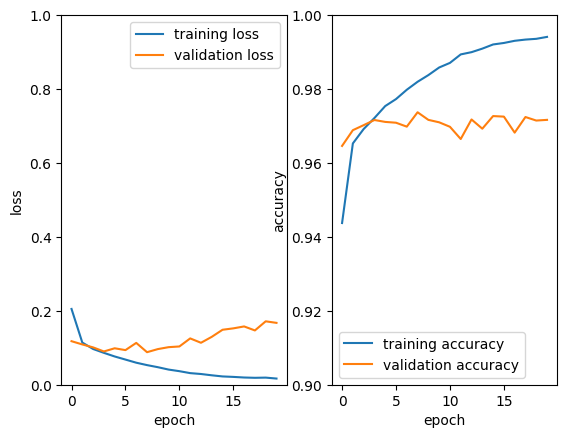

In [52]:
plt.subplot(1,2,1)
plt.plot(history0['loss'])
plt.plot(history0['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history0['accuracy'])
plt.plot(history0['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

{'precision': 0.13678806592016665,
 'recall': 1.0,
 'f1-measure': 0.24065711106747825}

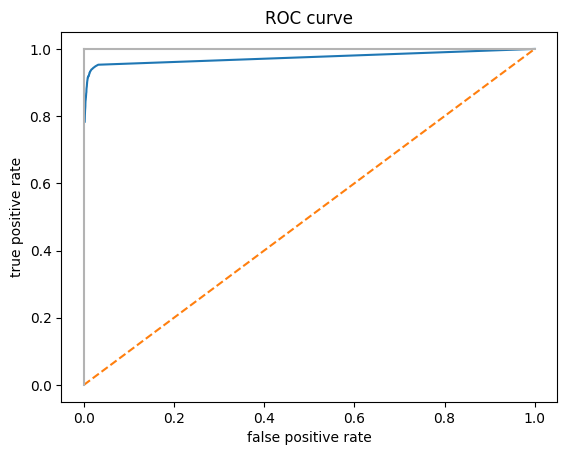

In [74]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

cm1 = confusion_matrix(model0, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

cm2 = confusion_matrix(model0, failure_types, val_tuple, threshold2)
metrics_report(cm2)

In [75]:
p = classes_proportion_correctly_classified(cm2, failure_types)

print(p)

np.mean(list(p.values()))

{'Center': 0.9197080291970803, 'Donut': 0.8764044943820225, 'Edge-Loc': 0.8537794299876085, 'Edge-Ring': 0.9877102199223803, 'Loc': 0.7935943060498221, 'Near-full': 1.0, 'Random': 0.9057971014492754, 'Scratch': 0.8540540540540541, 'none': 0.0}


0.7990052927824715

In [77]:
import os
import torch

save_dir = r"C:\Users\isang\OneDrive\Desktop\WM\models"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "model0.pth")
torch.save(model0.state_dict(), save_path)

## Augmented data

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model0_1(nn.Module):
    def __init__(self, num_classes=9):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=3, padding=1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=3, padding=1),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d((1,1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)            # [B,128,1,1]
        x = x.view(x.size(0), -1)       # [B,128]
        return self.classifier(x)       # **raw logits** [B,9]

# instantiate
model0_1 = Model0_1(num_classes=9)


In [99]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model0_1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model0_1.parameters(), lr=0.001)

num_epochs = 20
history0_1 = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(1, num_epochs + 1):
    # --- Training ---
    model0_1.train()
    running_loss = running_correct = running_total = 0

    for imgs, labels in train_aug_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model0_1(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss    += loss.item() * batch_size
        preds            = logits.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        running_total   += batch_size

    # 에폭 단위 성능 계산
    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    history0_1["loss"].append(epoch_loss)
    history0_1["accuracy"].append(epoch_acc)

    # --- Validation ---
    model0_1.eval()
    val_loss = val_correct = val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model0_1(imgs)
            loss   = criterion(logits, labels)

            bs = imgs.size(0)
            val_loss    += loss.item() * bs
            preds        = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += bs

    epoch_val_loss = val_loss / val_total
    epoch_val_acc  = val_correct / val_total
    history0_1["val_loss"].append(epoch_val_loss)
    history0_1["val_accuracy"].append(epoch_val_acc)

    print(f"Epoch {epoch}/{num_epochs} "
          f"- loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} | "
          f"val_loss: {epoch_val_loss:.4f}, val_acc: {epoch_val_acc:.4f}")


Epoch 1/20 - loss: 0.2398, acc: 0.9205 | val_loss: 0.1294, val_acc: 0.9618
Epoch 2/20 - loss: 0.1422, acc: 0.9509 | val_loss: 0.0894, val_acc: 0.9716
Epoch 3/20 - loss: 0.1173, acc: 0.9589 | val_loss: 0.0810, val_acc: 0.9749
Epoch 4/20 - loss: 0.1009, acc: 0.9644 | val_loss: 0.0833, val_acc: 0.9745
Epoch 5/20 - loss: 0.0909, acc: 0.9678 | val_loss: 0.0830, val_acc: 0.9742
Epoch 6/20 - loss: 0.0825, acc: 0.9705 | val_loss: 0.1034, val_acc: 0.9689
Epoch 7/20 - loss: 0.0751, acc: 0.9731 | val_loss: 0.0857, val_acc: 0.9737
Epoch 8/20 - loss: 0.0707, acc: 0.9748 | val_loss: 0.0851, val_acc: 0.9736
Epoch 9/20 - loss: 0.0656, acc: 0.9765 | val_loss: 0.0908, val_acc: 0.9736
Epoch 10/20 - loss: 0.0606, acc: 0.9783 | val_loss: 0.0864, val_acc: 0.9746
Epoch 11/20 - loss: 0.0565, acc: 0.9798 | val_loss: 0.0904, val_acc: 0.9753
Epoch 12/20 - loss: 0.0532, acc: 0.9807 | val_loss: 0.0983, val_acc: 0.9757
Epoch 13/20 - loss: 0.0501, acc: 0.9817 | val_loss: 0.1044, val_acc: 0.9724
Epoch 14/20 - loss: 0

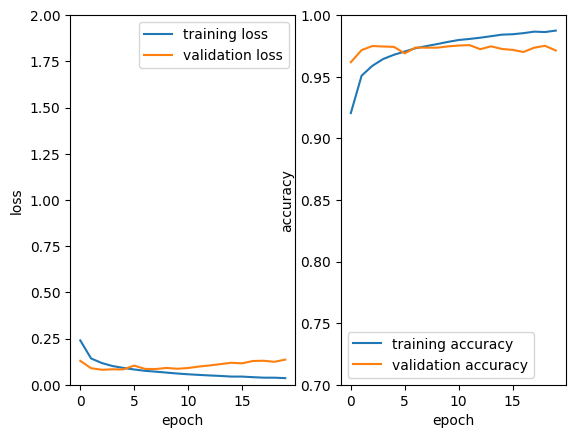

In [100]:
plt.subplot(1,2,1)
plt.plot(history0_1['loss'])
plt.plot(history0_1['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 2])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history0_1['accuracy'])
plt.plot(history0_1['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.7, 1])
plt.legend(['training accuracy', 'validation accuracy'])

{'precision': 0.14017860451328418,
 'recall': 1.0,
 'f1-measure': 0.24588885277868053}

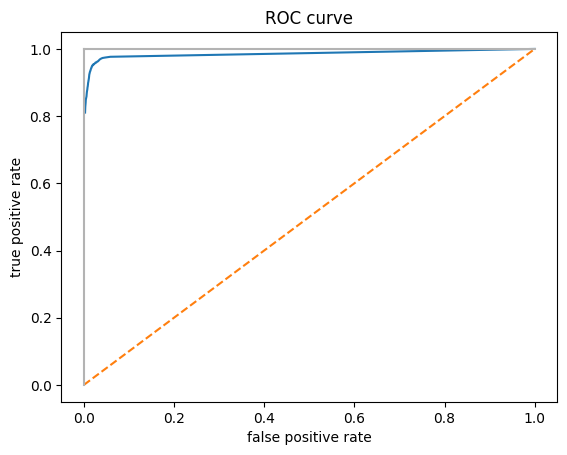

In [101]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

cm1 = confusion_matrix(model0_1, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

cm2 = confusion_matrix(model0_1, failure_types, val_tuple, threshold2)
metrics_report(cm2)

In [102]:
p = classes_proportion_correctly_classified(cm2, failure_types)

print(p)

np.mean(list(p.values()))

{'Center': 0.9576642335766423, 'Donut': 0.8651685393258427, 'Edge-Loc': 0.895910780669145, 'Edge-Ring': 0.9948253557567918, 'Loc': 0.8825622775800712, 'Near-full': 0.9166666666666666, 'Random': 0.9420289855072463, 'Scratch': 0.7621621621621621, 'none': 0.0}


0.801887666804952

In [103]:
import os
import torch

save_dir = r"C:\Users\isang\OneDrive\Desktop\WM\models"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "model0_1.pth")
torch.save(model0_1.state_dict(), save_path)

## Model 1 

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

class Model1(nn.Module):
    def __init__(self, num_classes=9):
        super(Model1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=3, padding=1),
        
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=3, padding=1),
        
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d((1, 1)),
        )
        
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)  # → (B, 128, 1, 1)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model1 = Model1(num_classes=9)

summary(model1, input_size=(3, 53, 52), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 53, 52]             896
              ReLU-2           [-1, 32, 53, 52]               0
         MaxPool2d-3           [-1, 32, 18, 18]               0
            Conv2d-4           [-1, 64, 18, 18]          18,496
              ReLU-5           [-1, 64, 18, 18]               0
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Conv2d-7            [-1, 128, 6, 6]          73,856
              ReLU-8            [-1, 128, 6, 6]               0
 AdaptiveMaxPool2d-9            [-1, 128, 1, 1]               0
           Linear-10                    [-1, 9]           1,161
Total params: 94,409
Trainable params: 94,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.83
Params size (MB): 0.36
Estimated Tot

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Model1(num_classes=9).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

num_epochs = 50

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0


history1 = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(1, num_epochs + 1):
    model1.train()
    running_loss = running_corrects = running_total = 0

    for imgs, labels in train_aug_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model1(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss    += loss.item() * batch_size
        preds = logits.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        running_total   += batch_size

    epoch_loss = running_loss / running_total
    epoch_acc  = running_corrects / running_total
    history1["loss"].append(epoch_loss)
    history1["accuracy"].append(epoch_acc)

    model1.eval()
    val_loss = val_corrects = val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model1(imgs)
            loss = criterion(logits, labels)

            bs = imgs.size(0)
            val_loss     += loss.item() * bs
            preds        = logits.argmax(dim=1)
            val_corrects += (preds == labels).sum().item()
            val_total   += bs

    epoch_val_loss = val_loss / val_total
    epoch_val_acc  = val_corrects / val_total
    history1["val_loss"].append(epoch_val_loss)
    history1["val_accuracy"].append(epoch_val_acc)

    print(f'Epoch {epoch}/{num_epochs}  '
          f'Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}  '
          f'Val Loss: {epoch_val_loss:.4f}  Val Acc: {epoch_val_acc:.4f}')

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        # Update best validation loss and reset counter
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model1.state_dict(), 'best_model.pth')
    # If no improvement, increment the counter
    else:
        # No improvement in validation loss
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping triggered')
            break

Epoch 1/50  Train Loss: 0.2311  Train Acc: 0.9234  Val Loss: 0.1030  Val Acc: 0.9694
Epoch 2/50  Train Loss: 0.1402  Train Acc: 0.9512  Val Loss: 0.0988  Val Acc: 0.9682
Epoch 3/50  Train Loss: 0.1142  Train Acc: 0.9601  Val Loss: 0.1042  Val Acc: 0.9674
Epoch 4/50  Train Loss: 0.0995  Train Acc: 0.9650  Val Loss: 0.1144  Val Acc: 0.9626
Epoch 5/50  Train Loss: 0.0891  Train Acc: 0.9682  Val Loss: 0.0896  Val Acc: 0.9714
Epoch 6/50  Train Loss: 0.0804  Train Acc: 0.9713  Val Loss: 0.0869  Val Acc: 0.9744
Epoch 7/50  Train Loss: 0.0745  Train Acc: 0.9736  Val Loss: 0.0787  Val Acc: 0.9760
Epoch 8/50  Train Loss: 0.0683  Train Acc: 0.9752  Val Loss: 0.1179  Val Acc: 0.9654
Epoch 9/50  Train Loss: 0.0632  Train Acc: 0.9772  Val Loss: 0.0888  Val Acc: 0.9742
Epoch 10/50  Train Loss: 0.0591  Train Acc: 0.9786  Val Loss: 0.1046  Val Acc: 0.9704
Epoch 11/50  Train Loss: 0.0550  Train Acc: 0.9800  Val Loss: 0.0995  Val Acc: 0.9719
Epoch 12/50  Train Loss: 0.0527  Train Acc: 0.9810  Val Loss: 0

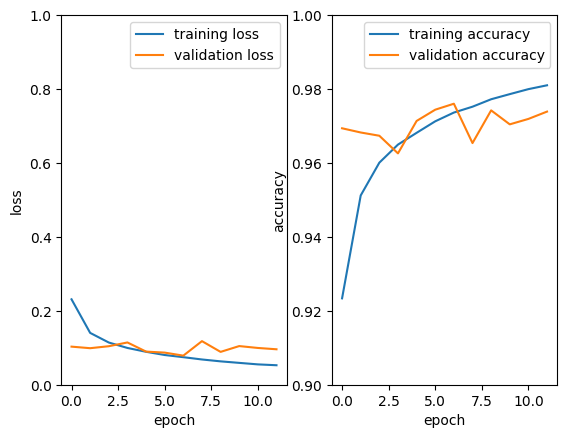

In [15]:
plt.subplot(1,2,1)
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])


In [19]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

val_dataset = torch.load("C://Users/isang/OneDrive/Desktop/WM/data/Val.pt")
val_tuple = from_DataBatch_to_list(val_dataset)

cm2 = confusion_matrix(model1, failure_types, val_tuple, threshold2)
p = classes_proportion_correctly_classified(cm2, failure_types)

print(p)

print(f"Mean Proportion : {np.mean(list(p.values()))}")

{'Center': 0.9693430656934306, 'Donut': 0.8876404494382022, 'Edge-Loc': 0.9182156133828996, 'Edge-Ring': 0.9902975420439845, 'Loc': 0.8078291814946619, 'Near-full': 0.9583333333333334, 'Random': 0.927536231884058, 'Scratch': 0.8486486486486486, 'none': 0.0}
Mean Proportion : 0.8119826739910243


In [22]:
import os
import torch

save_dir = r"C:\Users\isang\OneDrive\Desktop\WM\models"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "model1.pth")
torch.save(model1.state_dict(), save_path)